In [133]:
import os
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
np.random.seed(42)
import requests, zipfile, io
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
df1 = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)

In [135]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
for df in [df1]:
    df.drop(df.columns[list(df.columns[df.isnull().sum() > 0])], axis=1, inplace=True)
    df.columns = cols
    df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
    df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
    df['RUL'] = df['maxcycles'] - df['cycles']
    df['RUL_pct'] = df['RUL'].divide(df['maxcycles']).round(2)

In [136]:
srv= df.groupby('cycles')['unit'].count()


# Survival Probability for Jet Engine

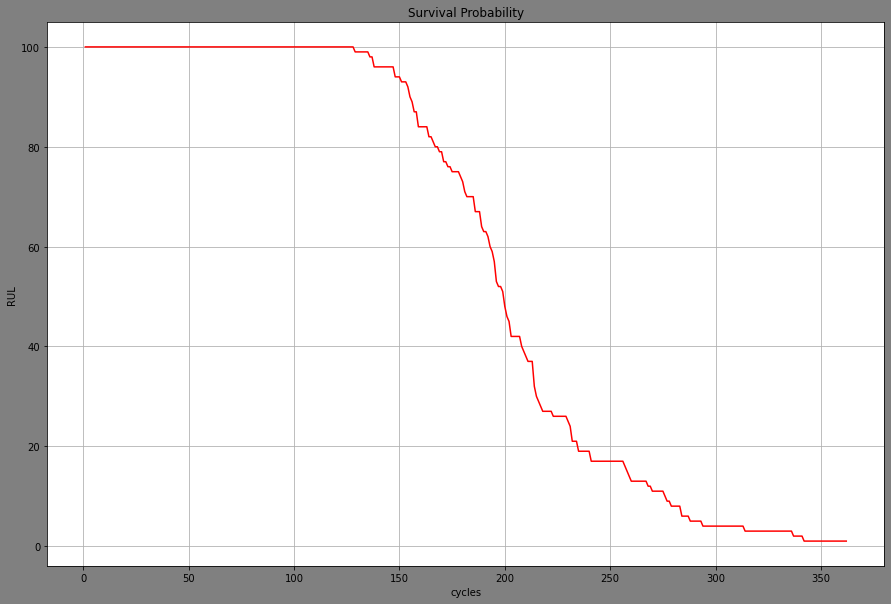

In [137]:
plt.rcParams['figure.facecolor'] = 'Gray'
plt.xlabel('Cycles')
plt.ylabel('RUL')
srv.plot(figsize=(15,10), title='Survival Probability', color= 'Red', grid= True)


# Standard Method | Kaplan - Meier estimator

The key idea of the Kaplan-Meier estimator is to break the estimation of the survival function S(t) into smaller steps depending on the observed event times. For each interval the probability of surviving until the end of this interval is calculated, given the following formula:

Where ni is a number of individuals who are at risk at time point ti and di is a number of subjects that experienced the event at time ti

When using Kaplan-Meier estimator, some assumptions must be taken into account:
All observations - both censored and defaulted - are used in estimation.
- There is no cohort effect on survival, so the subjects have the same survival probability regardless of their nature and time of appearance in study.
- Individuals who are censored have the same survival probabilities as those who are continued to be examined.
- The survival probability is equal for all subjects.

The main disadvantage of this method is that it cannot estimate survival probability considering all covariates in the data (it is an univariate approach) which shows no individual estimations but the overall population survival distribution. In comparison, semi- and parametric models allow to analyse all covariates and estimate S(t)
with respect to them.

## Jet Engine Data Representation | KM Estimator

In [138]:
srv1= srv.shift()- srv

In [139]:
srv1.dropna(inplace= True)

In [140]:
E= srv1.values

In [141]:
T= srv1.index.to_list()

In [142]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E) 

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 361 total observations, 296 right-censored observations>

In [143]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 361 total observations, 296 right-censored observations>

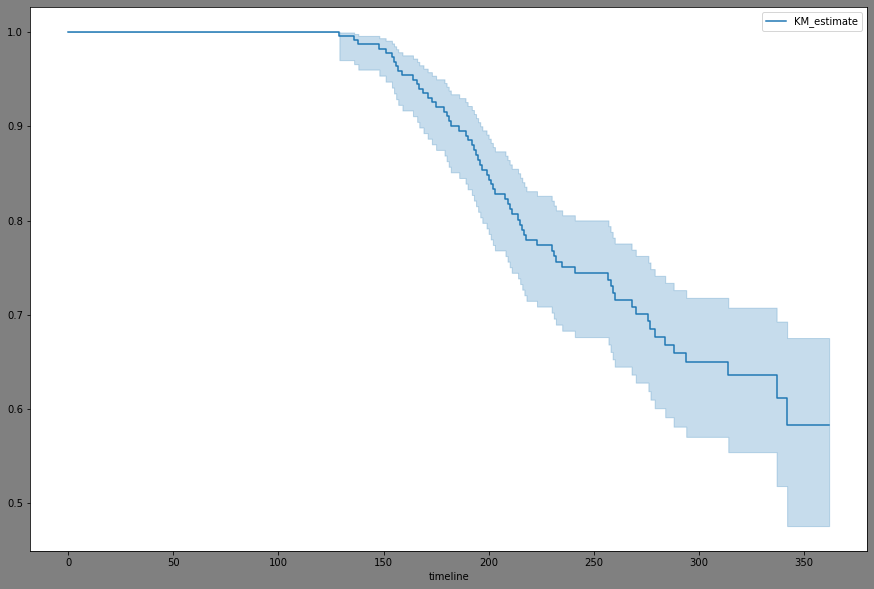

In [144]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function(figsize=(15,10)) # or just kmf.plot()

# Survival regression

Survival Regression involves utilizing not only the duration and the censorship variables but using additional data as covariates. We ‘regress’ these covariates against the duration variable.

## Cox’s proportional hazard model

The Cox Proportional Hazards Regression Analysis Model was introduced by Cox and it takes into account the effect of several variables at a time and examines the relationship of the survival distribution to these variables. 

The model works such that the log-hazard of an individual subject is a linear function of their static covariates and a population-level baseline hazard function that changes over time. 

The positive sign means that the risk of an event is higher, and thus the prognosis for the event of interest for that particular subject is higher. 

Cox Proportional Hazards Model is a semi-parametric model in the sense that the baseline hazard function does not have to be specified i.e it can vary, allowing a different parameter to be used for each unique survival time. But, it assumes that the rate ratio remains proportional throughout the follow-up period

# Python Implementation- Lifelines

In [168]:
rossi = load_rossi()
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


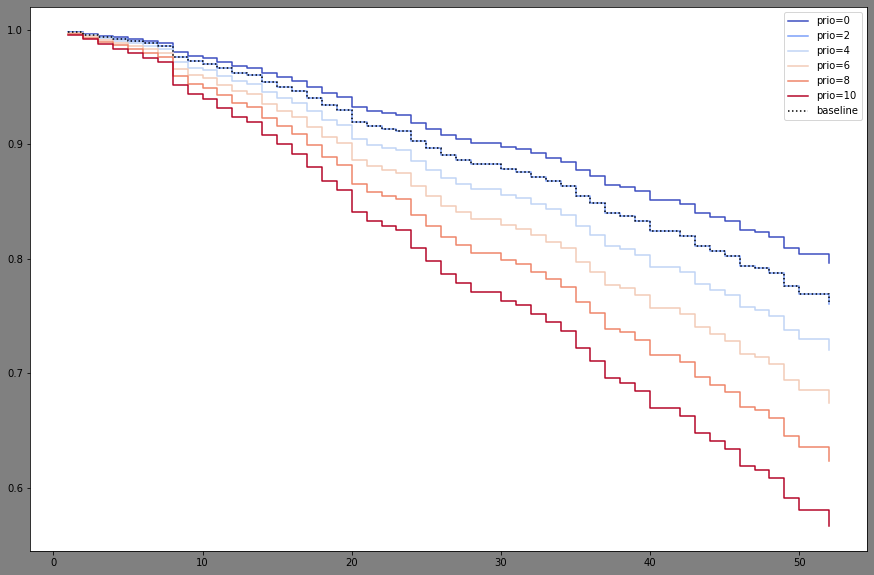

In [169]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')
cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm', figsize=(15,10))